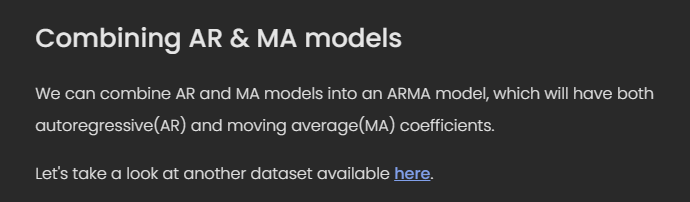

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split


In [16]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [18]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [19]:
# Load in data
ts = pd.read_csv('AR_MA_lesson_ts (1).csv', parse_dates = ['date'], index_col = 'date')
ts.head()


,value
date,
2022-05-25,-0.148001
2022-05-26,-0.187799
2022-05-27,-0.034606
2022-05-28,0.304207
2022-05-29,0.228702


In [20]:
# We see that the index is by day, so we will indicate the frequency as "D".
# We have daily data so we will set our frequency to D
ts.index.freq= "D"
ts.index



DatetimeIndex(['2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03',
               ...
               '2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10'],
              dtype='datetime64[ns]', name='date', length=200, freq='D')

In [21]:
# Check for nulls
ts.isna().sum().sum()



0

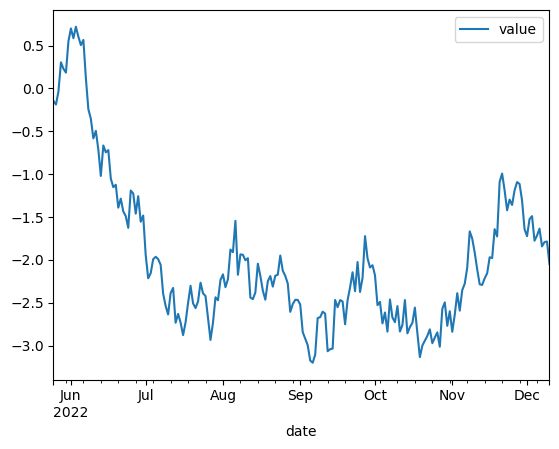

In [22]:
# Next, we will visualize our time series.
# Plot the time series
ts.plot();



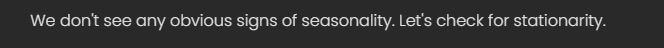

In [23]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.258272,1,198,0.185779,0.05,False


In [24]:
# Check to see how many differencing are needed
ndiffs(ts)


1

In [25]:
# We will apply one differencing and save the stationary data set for exploration.
# We need to apply differencing one time
ts_diff = ts.diff().dropna()
# Confirm stationarity with adfuller test
get_adfuller_results(ts_diff)


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-15.726403,0,198,0.0,0.05,True


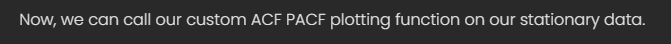

In [26]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig



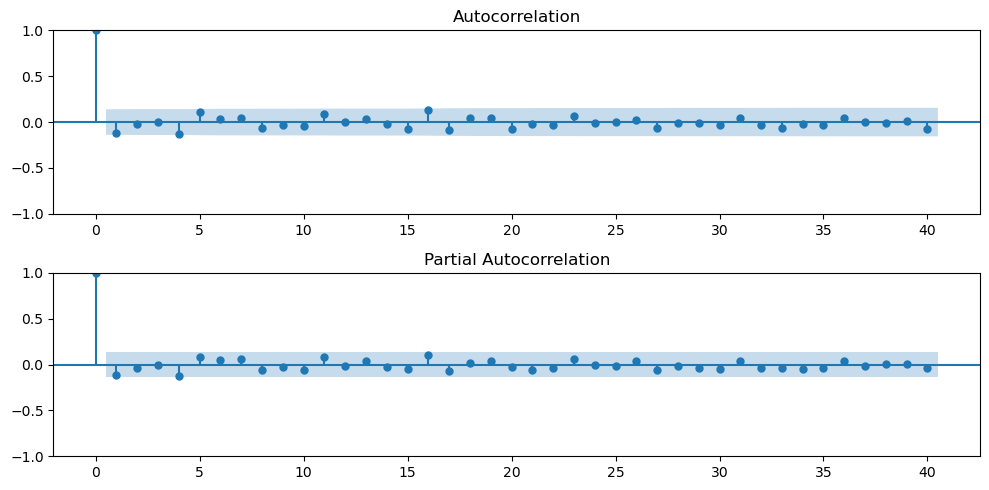

In [27]:
# Let's call our custom acf/pacf plot on our stationary (d = 1) data
plot_acf_pacf(ts_diff);



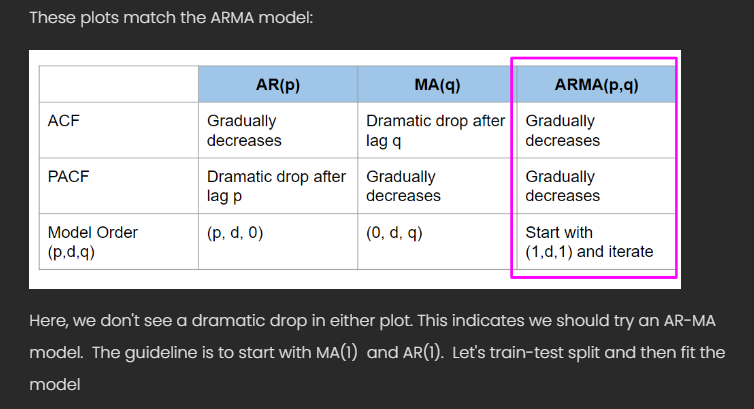

In [28]:
# First define the orders (p,d,q)
p = 1 # p is used for AR component of AR-MA model
d = 1 # 1 differcing needed to make stationary
q = 1 # q is used for MA component of AR-MA model
# Now instantiate the model with the data and fit
ar_ma_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_ma_model



NameError: name 'train' is not defined

In [ ]:
# Let's look at the params to see how having a p =1 and q = 1 affected the calculations. What do you expect to see?
# Obtain the parameters of the fit model
ar_ma_model.params



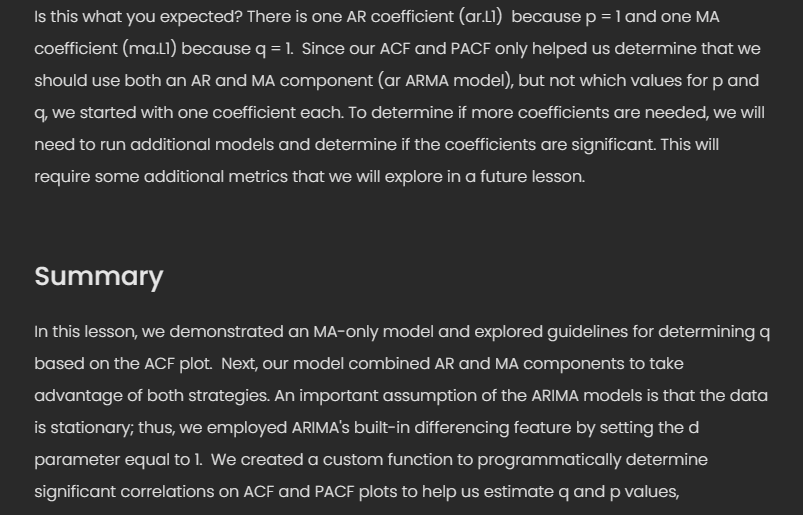

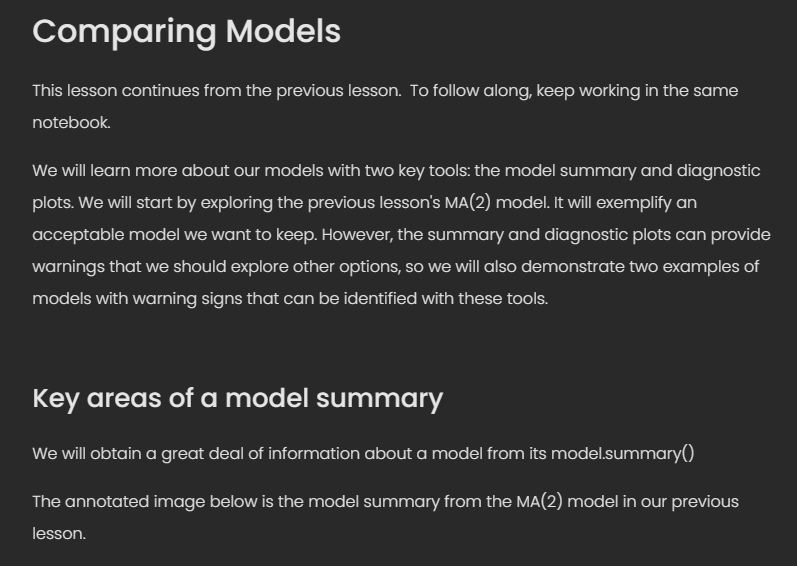

In [ ]:
# Obtain summary of model
ma_2_model.summary()



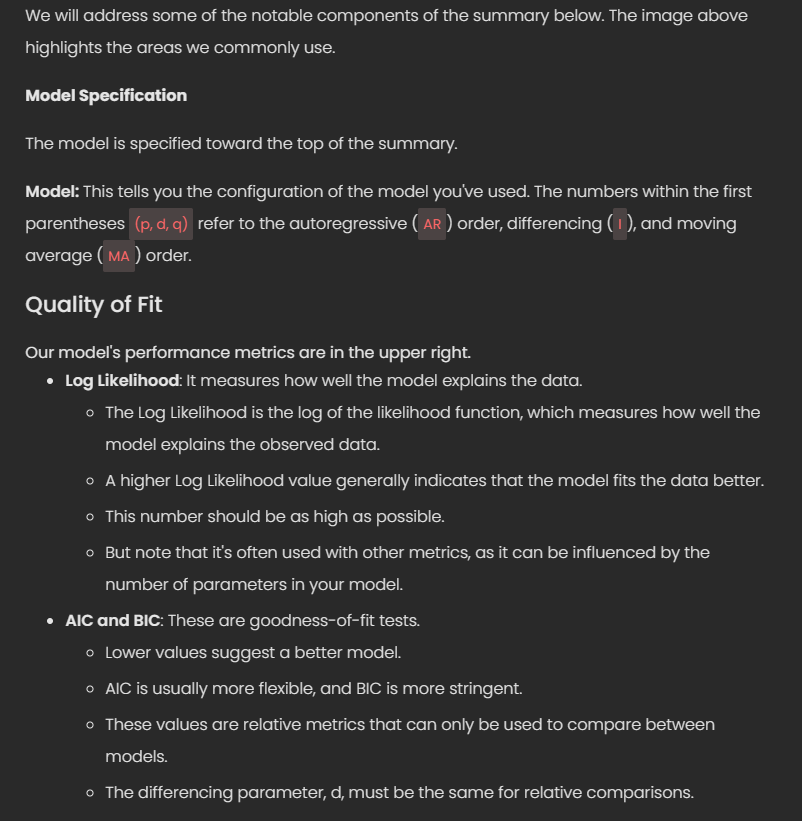